In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import numpy as np
import pandas as pd

# Load the processed dataset with features and target variable
df_final = pd.read_csv("../data/final_dataset.csv", index_col=0)

# Load the original dataset (if needed for reference or comparison)
df_original = pd.read_csv("../data/original_dataset.csv", index_col=0)

# Use the entire final dataframe as the dataset for training/testing
test_df = df_final

# Select feature columns for model input
X = test_df[['income_2012', 'rent_2012', 'college_2012']]

# Define the target variable indicating if an area was gentrified (binary)
y = test_df['gentrified']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Initialize a standard scaler to normalize features (mean=0, std=1)
scaler = StandardScaler()

# Create a logistic regression model with L2 regularization (penalty),
# regularization strength C=0.01, class weights balanced to handle class imbalance,
# and maximum iterations set to 1000 for convergence
model = LogisticRegression(penalty='l2', C=0.01, class_weight='balanced', max_iter=1000)

# Create a pipeline that scales the data then fits the logistic regression model
pipeline = make_pipeline(scaler, model)

# Fit the pipeline on the training data (scaling + model training)
pipeline.fit(X_train, y_train)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.01, class_weight='balanced',
                                    max_iter=1000))])

In [ ]:
# Filter the original dataset for records from the year 2013
df_start_t = df_original[df_original['year'] == 2013].copy()

# Filter the original dataset for records from the year 2023
df_end_t = df_original[df_original['year'] == 2023].copy()

# Rename relevant columns in the 2013 subset to indicate the year explicitly
df_start_t = df_start_t.rename(columns={
    'income': 'income_2013',
    'per_college_educated': 'college_2013',
    'median_contract_rent': 'rent_2013'
})

# Rename relevant columns in the 2023 subset to indicate the year explicitly
df_end_t = df_end_t.rename(columns={
    'income': 'income_2023',
    'per_college_educated': 'college_2023',
    'median_contract_rent': 'rent_2023'
})

# Merge the two subsets on 'zip_code' and 'msa_name' to align data from 2013 and 2023
# Using an inner join to keep only zip codes and MSAs present in both years
df_merged_t = pd.merge(df_start_t, df_end_t, on=['zip_code', 'msa_name'], how='inner')

# Display the merged dataframe, containing paired data for 2013 and 2023 for each zip code/MSA
df_merged_t


,zip_code,msa_name,year_x,income_2013,college_2013,rent_2013,year_y,income_2023,college_2023,rent_2023
0,602,"Aguadilla-Isabela-San Sebastian, PR MSA",2013,15663.0,20.1,2880.0,2023,21702.0,22.547348,3103.0
1,603,"Aguadilla-Isabela-San Sebastian, PR MSA",2013,15485.0,20.9,6168.0,2023,19243.0,23.917408,8389.0
2,610,"Aguadilla-Isabela-San Sebastian, PR MSA",2013,16707.0,13.8,2202.0,2023,23732.0,23.986928,2423.0
3,631,"Aguadilla-Isabela-San Sebastian, PR MSA",2013,11596.0,15.6,292.0,2023,18295.0,30.172414,182.0
4,662,"Aguadilla-Isabela-San Sebastian, PR MSA",2013,15600.0,18.0,5469.0,2023,20673.0,23.656758,5004.0
...,...,...,...,...,...,...,...,...,...,...
16313,99705,"Fairbanks, AK MSA",2013,76156.0,18.4,2192.0,2023,96966.0,23.235542,1702.0
16314,99709,"Fairbanks, AK MSA",2013,71287.0,39.5,4715.0,2023,82991.0,39.784946,4452.0
16315,99712,"Fairbanks, AK MSA",2013,85085.0,35.3,737.0,2023,103494.0,34.573561,683.0
16316,99714,"Fairbanks, AK MSA",2013,76250.0,35.3,89.0,2023,71042.0,24.044734,38.0


In [ ]:
# Calculate the change in income between 2023 and 2013 for each zip code/MSA
df_merged_t['income_change'] = df_merged_t['income_2023'] - df_merged_t['income_2013']

# Calculate the change in median contract rent between 2023 and 2013
df_merged_t['rent_change'] = df_merged_t['rent_2023'] - df_merged_t['rent_2013']

# Calculate the change in percentage of college-educated population between 2023 and 2013
df_merged_t['college_change'] = df_merged_t['college_2023'] - df_merged_t['college_2013']

# Compute the median changes in income, rent, and college education within each Metropolitan Statistical Area (MSA)
msa_medians_t = df_merged_t.groupby('msa_name')[['income_change', 'rent_change', 'college_change']].median().reset_index()

# Rename columns to clearly indicate these medians represent MSA-level median changes
msa_medians_t = msa_medians_t.rename(columns={
    'income_change': 'msa_income_median',
    'rent_change': 'msa_rent_median',
    'college_change': 'msa_college_median'
})

# Merge the MSA-level median change values back onto the original dataframe
# This allows comparison of each zip code’s change against its MSA median
df_test_t = pd.merge(df_merged_t, msa_medians_t, on='msa_name', how='left')


In [ ]:
# Create a new binary column 'gentrified' that marks zip codes as gentrified (1) if all of the following are true:
# 1) Income growth is greater than the median income growth in their MSA
# 2) Rent growth is greater than the median rent growth in their MSA
# 3) Increase in college-educated population is greater than the median increase in their MSA
# Otherwise, mark as 0 (not gentrified)
df_test_t['gentrified'] = (
    (df_test_t['income_change'] > df_test_t['msa_income_median']) &
    (df_test_t['rent_change'] > df_test_t['msa_rent_median']) &
    (df_test_t['college_change'] > df_test_t['msa_college_median'])
).astype(int)

# Display the dataframe with the new 'gentrified' indicator
df_test_t


,zip_code,msa_name,year_x,income_2013,college_2013,rent_2013,year_y,income_2023,college_2023,rent_2023,income_change,rent_change,college_change,msa_income_median,msa_rent_median,msa_college_median,gentrified
0,602,"Aguadilla-Isabela-San Sebastian, PR MSA",2013,15663.0,20.1,2880.0,2023,21702.0,22.547348,3103.0,6039.0,223.0,2.447348,6286.0,222.0,3.828907,0
1,603,"Aguadilla-Isabela-San Sebastian, PR MSA",2013,15485.0,20.9,6168.0,2023,19243.0,23.917408,8389.0,3758.0,2221.0,3.017408,6286.0,222.0,3.828907,0
2,610,"Aguadilla-Isabela-San Sebastian, PR MSA",2013,16707.0,13.8,2202.0,2023,23732.0,23.986928,2423.0,7025.0,221.0,10.186928,6286.0,222.0,3.828907,0
3,631,"Aguadilla-Isabela-San Sebastian, PR MSA",2013,11596.0,15.6,292.0,2023,18295.0,30.172414,182.0,6699.0,-110.0,14.572414,6286.0,222.0,3.828907,0
4,662,"Aguadilla-Isabela-San Sebastian, PR MSA",2013,15600.0,18.0,5469.0,2023,20673.0,23.656758,5004.0,5073.0,-465.0,5.656758,6286.0,222.0,3.828907,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16313,99705,"Fairbanks, AK MSA",2013,76156.0,18.4,2192.0,2023,96966.0,23.235542,1702.0,20810.0,-490.0,4.835542,13570.0,-52.5,-4.061560,0
16314,99709,"Fairbanks, AK MSA",2013,71287.0,39.5,4715.0,2023,82991.0,39.784946,4452.0,11704.0,-263.0,0.284946,13570.0,-52.5,-4.061560,0
16315,99712,"Fairbanks, AK MSA",2013,85085.0,35.3,737.0,2023,103494.0,34.573561,683.0,18409.0,-54.0,-0.726439,13570.0,-52.5,-4.061560,0
16316,99714,"Fairbanks, AK MSA",2013,76250.0,35.3,89.0,2023,71042.0,24.044734,38.0,-5208.0,-51.0,-11.255266,13570.0,-52.5,-4.061560,0


In [ ]:
test_df_t = df_test_t
from sklearn.metrics import classification_report

# Prepare features and target for evaluation
# Select 2013 features and rename columns to match training feature names
X_eval = test_df_t[['income_2013', 'rent_2013', 'college_2013']]
X_eval.columns = ['income_2012', 'rent_2012', 'college_2012']
y_eval = test_df_t['gentrified']  # True labels

# Scale features with the same scaler used during training
X_eval_scaled = scaler.transform(X_eval)

# Get predicted probabilities for the positive class (gentrified)
y_probs = model.predict_proba(X_eval_scaled)[:, 1]

# Import metrics to evaluate model performance
from sklearn.metrics import log_loss, roc_auc_score, accuracy_score, roc_curve

# Calculate negative log loss (approximate log-likelihood)
ll = -log_loss(y_eval, y_probs, normalize=False)

# Calculate ROC AUC score (area under the curve)
auc = roc_auc_score(y_eval, y_probs)

# Calculate ROC curve points (false positive rate, true positive rate, thresholds)
fpr, tpr, thresholds = roc_curve(y_eval, y_probs)

# Calculate accuracy using model predictions with default 0.5 threshold
acc = accuracy_score(y_eval, model.predict(X_eval_scaled))

# Print evaluation metrics
print(f'Log Likelihood (approx): {ll}')
print(f'AUC: {auc:.3f}')
print(f'Accuracy: {acc:.3f}')

# Convert probabilities to class predictions using threshold 0.5
y_pred = (y_probs >= 0.5).astype(int)

# Print detailed classification report (precision, recall, f1-score)
print("Classification Report: ")
print(classification_report(y_eval, y_pred))


Log Likelihood (approx): -11207.717670414399
AUC: 0.589
Accuracy: 0.616
Classificaiton Report: 
              precision    recall  f1-score   support

           0       0.90      0.63      0.74     14295
           1       0.16      0.51      0.25      2023

    accuracy                           0.62     16318
   macro avg       0.53      0.57      0.50     16318
weighted avg       0.81      0.62      0.68     16318



## Forecast 2035 Probability

In [ ]:
# Reshape df_original from long to wide format:
# Each row is identified by 'zip_code' and 'msa_name'
# Columns are created for each variable-year combination (e.g., income_2013, rent_2023)
wide_table = df_original.pivot(index=['zip_code', 'msa_name'], columns='year')

# Flatten the multi-index columns created by pivot, format as 'variable_year'
wide_table.columns = [f'{var}_{year}' for var, year in wide_table.columns]

# Drop rows with any missing values to keep only complete cases
wide_table = wide_table.dropna()

# Use the cleaned wide table as the main dataset for further processing
df_test = wide_table

# Read forecasted data for the year 2030
df_2030 = pd.read_csv("../data/forecasted_data_2030.csv")

# Merge the 2030 forecasted variables into df_test on 'zip_code'
# We merge only selected columns from the forecast data
# 'how=left' keeps all rows in df_test, adds 2030 forecast where available
df_test = df_test.merge(
    df_2030[['zip_code', 'income_2030', 'rent_2030', 'college_2030']],
    on='zip_code',
    how='left'
)

# Display the updated dataframe with forecast data merged
df_test


,zip_code,income_2012,income_2013,income_2014,income_2015,income_2016,income_2017,income_2018,income_2019,income_2020,...,median_contract_rent_2017,median_contract_rent_2018,median_contract_rent_2019,median_contract_rent_2020,median_contract_rent_2021,median_contract_rent_2022,median_contract_rent_2023,income_2030,rent_2030,college_2030
0,602,15106.0,15663.0,16353.0,16079.0,15511.0,16190.0,16358.0,16807.0,16771.0,...,3225.0,3257.0,3212.0,3034.0,3076.0,3147.0,3103.0,19337,3931,22.6
1,603,15079.0,15485.0,16323.0,16804.0,16681.0,16645.0,16603.0,16049.0,15786.0,...,7767.0,8081.0,8110.0,8333.0,8041.0,8366.0,8389.0,19302,8080,23.7
2,610,16923.0,16707.0,17265.0,17475.0,17751.0,18741.0,19309.0,19898.0,20167.0,...,2040.0,2064.0,2037.0,2288.0,2482.0,2389.0,2423.0,21663,2816,16.6
3,612,18111.0,17848.0,17752.0,17229.0,17208.0,17744.0,18171.0,18741.0,19402.0,...,8111.0,7894.0,8485.0,8865.0,8853.0,8781.0,9103.0,23184,9031,26.5
4,616,16279.0,15342.0,15115.0,13705.0,14490.0,14918.0,16018.0,17007.0,18903.0,...,897.0,858.0,831.0,798.0,976.0,1027.0,1047.0,20838,1014,17.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15701,99703,46063.0,50403.0,47596.0,53557.0,53031.0,54526.0,54225.0,55503.0,56792.0,...,1910.0,2005.0,2050.0,1952.0,2093.0,1935.0,1903.0,58965,2195,27.0
15702,99705,80606.0,76156.0,76085.0,74920.0,76973.0,81045.0,81235.0,80875.0,85739.0,...,2449.0,2634.0,2488.0,2408.0,1988.0,1742.0,1702.0,103182,2679,20.4
15703,99709,72900.0,71287.0,73871.0,77209.0,83580.0,84175.0,88121.0,87055.0,77756.0,...,4454.0,4243.0,4317.0,4649.0,4377.0,4455.0,4452.0,93318,5981,44.6
15704,99712,88716.0,85085.0,88517.0,86354.0,90394.0,86503.0,86122.0,88502.0,89688.0,...,1041.0,1122.0,959.0,858.0,797.0,750.0,683.0,113564,1121,38.6


In [ ]:
# Select the forecasted 2030 features for prediction, dropping rows with missing values
X_future = df_test[['income_2030', 'rent_2030', 'college_2030']].dropna().copy()

# Rename columns to match model training feature names (from 2012 data)
X_future.columns = ['income_2012', 'rent_2012', 'college_2012']

# Scale the features using the previously fitted scaler to match model input scale
X_future_scaled = scaler.transform(X_future)

# Predict the probability of gentrification in 2035 using the trained logistic regression model
gentrification_probs_2035 = model.predict_proba(X_future_scaled)[:, 1]

# Assign the predicted probabilities back to the original dataframe, aligned by index
df_test.loc[X_future.index, 'gentrification_prob_2035'] = gentrification_probs_2035

# Display the updated dataframe with gentrification probability predictions
df_test

# Save the dataframe with predictions to a CSV file for further use or analysis
df_test.to_csv("logistic_by_zipcode.csv")


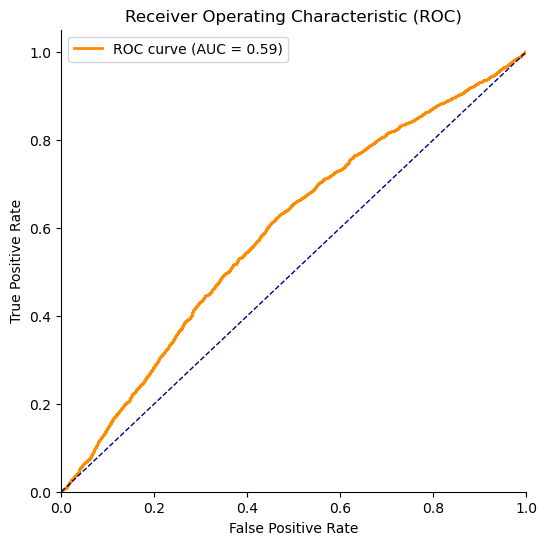

In [ ]:
import matplotlib.pyplot as plt

# Create a figure and a set of subplots with a specific size
fig, ax = plt.subplots(figsize=(6, 6))

# Plot the ROC curve with false positive rate (fpr) on x-axis and true positive rate (tpr) on y-axis
# The curve color is dark orange and line width is 2
# Include the AUC value in the legend for reference
ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.2f})')

# Plot the diagonal dashed line representing a random classifier (no skill)
ax.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')

# Set x-axis limits from 0 to 1
ax.set_xlim([0.0, 1.0])

# Set y-axis limits from 0 to slightly above 1 for better visualization
ax.set_ylim([0.0, 1.05])

# Label x-axis as False Positive Rate
ax.set_xlabel('False Positive Rate')

# Label y-axis as True Positive Rate
ax.set_ylabel('True Positive Rate')

# Set plot title
ax.set_title('Receiver Operating Characteristic (ROC)')

# Add legend in the upper left corner of the plot
ax.legend(loc="upper left")

# Remove the top and right spines (borders) of the plot for a cleaner look
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Display the plot
plt.show()
